<a href="https://colab.research.google.com/github/KrishGuptareal/cifer_10/blob/main/cifer_10_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# **Getting** **dataset**

In [6]:
transform = transforms.Compose([
    #for data augmentatiobn
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    #converting image to tensor
    transforms.ToTensor(),
    #
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean
                         (0.247, 0.243, 0.261))    # std
])

In [7]:
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)


100%|██████████| 170M/170M [07:14<00:00, 393kB/s]


In [8]:
len(trainset) ,len(testset)

(50000, 10000)

In [9]:
img,lbl=trainset[0]
img,lbl

(tensor([[[-0.3700,  0.0269, -0.0208,  ..., -0.9257, -1.9895, -1.9895],
          [-0.2430,  0.0586,  0.1698,  ..., -1.4814, -1.9895, -1.9895],
          [-0.0366,  0.0745,  0.1698,  ..., -0.9416, -1.9895, -1.9895],
          ...,
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895]],
 
         [[-0.9354, -0.7094, -0.7417,  ..., -1.3066, -1.9844, -1.9844],
          [-0.8063, -0.6610, -0.5642,  ..., -1.7746, -1.9844, -1.9844],
          [-0.6126, -0.6288, -0.5642,  ..., -1.2259, -1.9844, -1.9844],
          ...,
          [-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844],
          [-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844],
          [-1.9844, -1.9844, -1.9844,  ..., -1.9844, -1.9844, -1.9844]],
 
         [[-1.1999, -1.1247, -1.1698,  ..., -1.3351, -1.7107, -1.7107],
          [-1.1548, -1.1398,

In [10]:
img.shape,lbl

(torch.Size([3, 32, 32]), 6)

In [11]:
class_label=trainset.classes
class_label

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# visualizing data

In [12]:
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5   # [-1,1] -> [0,1]

Text(0.5, 1.0, 'frog')

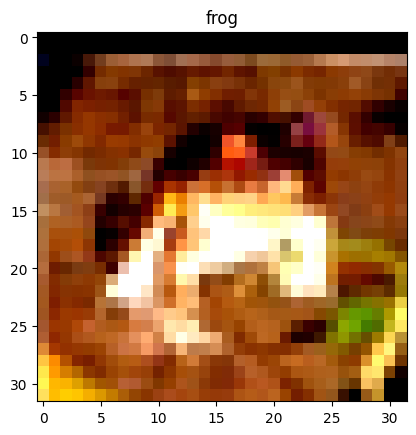

In [13]:
img, lbl = trainset[0]
img = denormalize(img)              # de-normalize
plt.imshow(img.permute(1, 2, 0))    # (C,H,W) -> (H,W,C)
plt.title(class_label[lbl])


In [14]:
print(trainset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# ***Batching Data***

In [15]:
len(train_loader),len(test_loader)

(782, 157)

In [16]:
image,label=next(iter(train_loader))
image.shape,label.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

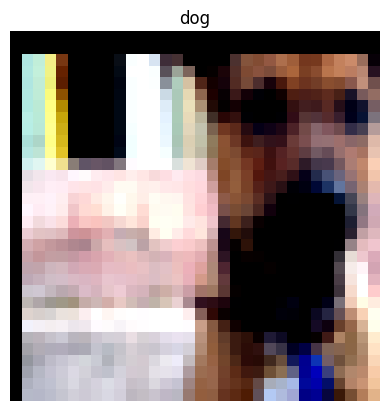

In [17]:

#Show a sample
torch.manual_seed(42)
random_idx=torch.randint(0,len(image),size=[1]).item()
img,lbl=image[random_idx],label[random_idx]
img=denormalize(img)
plt.imshow(img.permute(1,2,0))
plt.title(class_label[lbl])
plt.axis(False)

# *Model*

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class net(nn.Module):
  def __init__(self):
    super(net,self).__init__()

  # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # input: 3x32x32 → 32x32x32
    self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # input: 32x32x32 → 64x32x32
    self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)                           # halves size: 64x32x32 → 64x16x16
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128x16x16
    self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2)                           # → 128x8x8
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv4_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(2, 2)


    self.fc1=nn.Linear(256*4*4,128)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,10)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv1_2(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv2_2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv3_3(x))
    x = self.pool2(x)
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv4_4(x))
    x = self.pool3(x)

    # Flatten
    x = x.view(-1, 256*4*4)

    # Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = net().to(device)

# `Loss fn and optimizers`

In [20]:
#Setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),
                          lr=0.1)

# Training

In [21]:
ep=20
for e in range(ep):
  for img,lbl in train_loader:
    img, lbl = img.to(device), lbl.to(device)
    optimizer.zero_grad()
    out=model(img)
    loss=loss_fn(out,lbl)
    loss.backward()
    optimizer.step()
  print(f"Epoch {e+1}/{ep}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 2.2976
Epoch 2/20, Loss: 2.3143
Epoch 3/20, Loss: 2.3125
Epoch 4/20, Loss: 2.6106
Epoch 5/20, Loss: 1.8509
Epoch 6/20, Loss: 1.2723
Epoch 7/20, Loss: 1.7199
Epoch 8/20, Loss: 1.7782
Epoch 9/20, Loss: 1.0209
Epoch 10/20, Loss: 0.7557
Epoch 11/20, Loss: 0.5016
Epoch 12/20, Loss: 0.6410
Epoch 13/20, Loss: 0.3318
Epoch 14/20, Loss: 0.5890
Epoch 15/20, Loss: 0.4433
Epoch 16/20, Loss: 0.3781
Epoch 17/20, Loss: 0.6478
Epoch 18/20, Loss: 0.3435
Epoch 19/20, Loss: 0.5407
Epoch 20/20, Loss: 0.3068


In [22]:
correct=0
total=0
with torch.no_grad():
  for img,lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)
    output=model(img)
    #extracting the output
    _,pred=torch.max(output,1)
    total += lbl.size(0)
    correct += (pred == lbl).sum().item()

print("Test Accuracy: {:.2f}%".format(100 * correct / total))

Test Accuracy: 79.30%


# ***model 2(pretrained model)***

In [23]:
from torchvision.models import resnet18

In [26]:
model2 = resnet18(weights='IMAGENET1K_V1')
model2.fc = nn.Linear(model2.fc.in_features, 10)

In [27]:
for param in model.parameters():
    param.requires_grad = False  # freeze all layers
model2.fc.requires_grad = True    # only train final layer

In [28]:
transform = transforms.Compose([
    #for data augmentatiobn
    transforms.Resize((224, 224)),  # resize CIFAR-10 images
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    #converting image to tensor
    transforms.ToTensor(),
    #
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])

In [29]:
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

In [30]:
img,lbl=trainset[0]
img.shape,lbl

(torch.Size([3, 224, 224]), 6)

In [37]:
model2=model2.to(device)
optimizer = torch.optim.Adam(model2.fc.parameters(), lr=0.001)


In [38]:
ep=20
for e in range(ep):
  for img,lbl in train_loader:
    img, lbl = img.to(device), lbl.to(device)
    optimizer.zero_grad()
    out=model2(img)
    loss=loss_fn(out,lbl)
    loss.backward()
    optimizer.step()
  print(f"Epoch {e+1}/{ep}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.8081
Epoch 2/20, Loss: 1.1257
Epoch 3/20, Loss: 0.4119
Epoch 4/20, Loss: 0.3803
Epoch 5/20, Loss: 0.6707
Epoch 6/20, Loss: 0.2961
Epoch 7/20, Loss: 0.6884
Epoch 8/20, Loss: 0.7571
Epoch 9/20, Loss: 0.6112
Epoch 10/20, Loss: 0.4438
Epoch 11/20, Loss: 0.6985
Epoch 12/20, Loss: 1.3424
Epoch 13/20, Loss: 0.6169
Epoch 14/20, Loss: 1.6601
Epoch 15/20, Loss: 0.2369
Epoch 16/20, Loss: 0.5245
Epoch 17/20, Loss: 0.5779
Epoch 18/20, Loss: 0.6190
Epoch 19/20, Loss: 0.5186
Epoch 20/20, Loss: 0.8436


In [39]:
correct=0
total=0
with torch.no_grad():
  for img,lbl in test_loader:
    img, lbl = img.to(device), lbl.to(device)
    output=model2(img)
    #extracting the output
    _,pred=torch.max(output,1)
    total += lbl.size(0)
    correct += (pred == lbl).sum().item()

print("Test Accuracy: {:.2f}%".format(100 * correct / total))

Test Accuracy: 80.31%
